# Outline

** Evaluating quality of feedback**

1. Modeling feedback bias
    * Revenge patterns in evaluation of feedback quality
    * Length of feedback vs. perceived quality <br><br>
    
2. Results
    * Time spent on feedback vs. feedback quality
    * Handin quality vs. feedback quality. Does bad handins get bad feedback?
    * Handin ability vs. feedback ability. Does good students give good feedback?
    * Evaluation criteria: Common characteristics of criteria that leads to good feedback.

# Modeling feedback bias

### Imports

In [208]:
%matplotlib inline
import numpy as np
import pymongo as pm
from bson.objectid import ObjectId
from collections import defaultdict, Counter
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from scipy import stats
import dateutil.parser
from langdetect import detect
from afinn import Afinn
import enchant
from matplotlib.colors import LinearSegmentedColormap

### Settings

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.style.use(["classic"])

### Utility functions

In [3]:
def get_connection():
    con = pm.Connection()
    db = con.heroku_rnwkcq9r
    return db

## Revenge patterns in evaluation of feedback quality

Is negative feedback rated as less constructive? Is positive feedback rated as more constructive?

In [4]:
# Connect to database
db = get_connection()

In [6]:
# Main data structure to write to. Every entry is feedback from one person to one handin
ds = defaultdict(lambda: defaultdict(list))

# Book keeping for normalization
handins = defaultdict(list)
assignments = defaultdict(list)
courses = defaultdict(list)

length_of_collection = db['answer'].find({"numerical_answer": {"$exists": True}}).count()
start_date = dateutil.parser.parse('2016-03-30T22:01:37.000Z')

# For printing progress
increments = np.arange(0, length_of_collection, length_of_collection/10)

count_total = 0
count_missing_numericalAnswer = 0
count_missing_feedback_grade = 0
count_no_answer = 0
count_too_old = 0
count_demo = 0

c = -1
for t in db['answer'].find({"numerical_answer": {"$exists": True}}):
    
    c += 1  # Progress counter
    if c in increments:
        print str(list(increments).index(c) * 10) + "%",
        
    # Only use data from after march 31. 2016 where constructive score feature was implemented
    if t['report_grade'].generation_time < start_date:
        count_too_old += 1
        continue
    
    # Question pertaining to answer in loop
    question = list(db['question'].find({"_id": t["question"]}))[0]
    
    # Not all questions have numerical answers. Skip the ones that doesn't
    if not "numericalAnswers" in question:
        count_missing_numericalAnswer += 1
        continue
    
    normalized_score = \
        t['numerical_answer'] * 1.0 / \
        max(map(int, question['numericalAnswers'].keys()))
    
    # Handle incomplete data
    try:
        report_grade = list(db['report_grade'].find({"_id": t['report_grade']}))[0]
        course = list(db['assignment'].find({"_id": report_grade['assignment']}))[0]['course']
    except IndexError:
        # document doesn't exist in report_grade
        count_no_answer += 1
        continue
        
    # Avoid demo courses!
    if "demo" in list(db['course'].find({"_id": course}))[0]["title"].lower():
        continue
        
    # Some gradings don't have feedback grades
    if not "feedback_grade" in report_grade:
        count_missing_feedback_grade += 1
        feedback_grade = 0
    else:
        feedback_grade = report_grade['feedback_grade']
    
    count_total += 1
    
    giver_handin = str(report_grade['giver']) + str(report_grade['handin'])
    
    ds[giver_handin]['normalized_scores'].append(normalized_score)
    ds[giver_handin]['feedback_grade'] = feedback_grade
    
    # For later normalization wrt. different stuff
    ds[giver_handin]['handin'] = report_grade['handin']
    ds[giver_handin]['assignment'] = report_grade['assignment']
    ds[giver_handin]['course'] = course
    
    assignments[report_grade['assignment']].append(normalized_score)
    handins[report_grade['handin']].append(normalized_score)
    courses[course].append(normalized_score)

 0% 10% 20% 30% 40% 50% 60% 70% 80% 90%


###  Data report

In [8]:
print "Entries before march 31. 2016:", count_too_old * 1.0 / count_total
print "Missing numerical_answer:", count_missing_numericalAnswer * 1.0 / count_total
print "Missing feedback_grade:", count_missing_feedback_grade * 1.0 / count_total
print "Entries of demo courses:", count_demo * 1.0 / count_total
print "Causes IndexError:", count_no_answer * 1.0 / count_total

 Entries before march 31. 2016: 0.873025516403
Missing numerical_answer: 0.0
Missing feedback_grade: 0.786915648782
Entries of demo courses: 0.0
Causes IndexError: 0.000255803542879


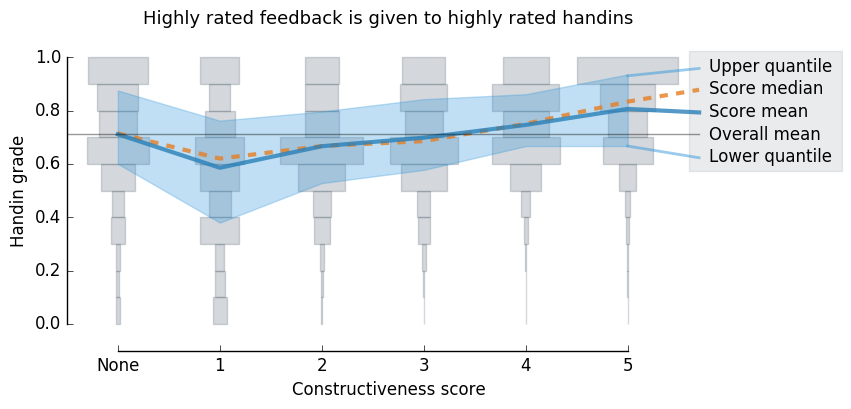

In [24]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(np.mean(v['normalized_scores']))
    
nbins=10
fig, ax = plt.subplots(1, 1, figsize=(10, 4), frameon=False)

hists_mean = np.mean([v for h in hists.values() for v in h])

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    medians.append(np.median(h))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, bins = np.histogram(h, bins=np.linspace(0, 1, 11), normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        w = bc/3.75
        rect = mpatches.Rectangle([v-w/2, b], w, 1.0/nbins, lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

annotation_scale = 0.85
plt.plot(range(6)+[5.7], medians+[hists_mean + 0.08 + 0.1 * annotation_scale], color="#e67e22", lw=3, ls="--", alpha=0.8)
plt.plot(range(6)+[5.7], means+[hists_mean + 0.08 + 0.0 * annotation_scale], color="#2980b9", lw=3, ls="-", alpha=0.8)
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)
plt.fill_between(range(6), lq, uq, color="#3498db", alpha="0.3")

plt.plot([5, 5.7], np.array(uq[-1:] + [hists_mean + 0.08 + 0.2 * annotation_scale])-0.005, color="#3498db", lw=2, alpha=0.5)
plt.plot([5, 5.7], [lq[-1], hists_mean + 0.08 - 0.2 * annotation_scale], color="#3498db", lw=2, alpha=0.5)
plt.plot([-0.5, 5.7], [hists_mean, hists_mean], c="k", lw=1, alpha=0.4)

# Legend
rect = mpatches.Rectangle([5.6, hists_mean + 0.03 - 0.2 * annotation_scale], 1.5, 0.45, lw=0)
collection = PatchCollection([rect], color="#2c3e50", alpha=0.1)
ax.add_collection(collection)

plt.annotate("Upper quantile", (5.8, hists_mean + 0.064 + 0.2 * annotation_scale), fontsize=12)
plt.annotate("Score median", (5.8, hists_mean + 0.064 + 0.1 * annotation_scale), fontsize=12)
plt.annotate("Score mean", (5.8, hists_mean + 0.064 + 0.0 * annotation_scale), fontsize=12)
plt.annotate("Overall mean", (5.8, hists_mean + 0.064 - 0.1 * annotation_scale), fontsize=12)
plt.annotate("Lower quantile", (5.8, hists_mean + 0.064 - 0.2 * annotation_scale), fontsize=12)

# Axes
plt.xlim([-0.5, 7.1])
plt.ylim([-0.1, 1.1])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Constructiveness score                         ", fontsize=12)
plt.ylabel("Handin grade", fontsize=12)

sns.despine(trim=True)
plt.title("Highly rated feedback is given to highly rated handins                       ", fontsize=13)
plt.savefig("../figures/revenge0.png")
plt.show()

### Effect size

In [25]:
def _slope(hists):
    x, y = [], []
    for v, h in hists.items():
        if v > 0:
            x.extend([v]*len(h))
            y.extend(h)
    return stats.linregress(x, y)

slope, intercept, r_value, p_value, std_err = _slope(hists)
print slope, intercept, r_value, p_value, std_err

# shared variance
print r_value ** 2

0.0506091076211 0.548485488054 0.309274241914 2.38761258956e-58 0.00306367867279
0.0956505567114


The highest feedback quality grades are given to reviews that assign high scores to handins. This could mean that, as suspected, students have a tendency to rate positie feedback as good, but it could also mean that feedback is in fact better when handins are better. It is possible that there is a bias towards putting in more effort to giving better feedback when reviewing a handins that "deserve it", as opposed to work where the grader assesses that that the graded student didn't try hard enough.

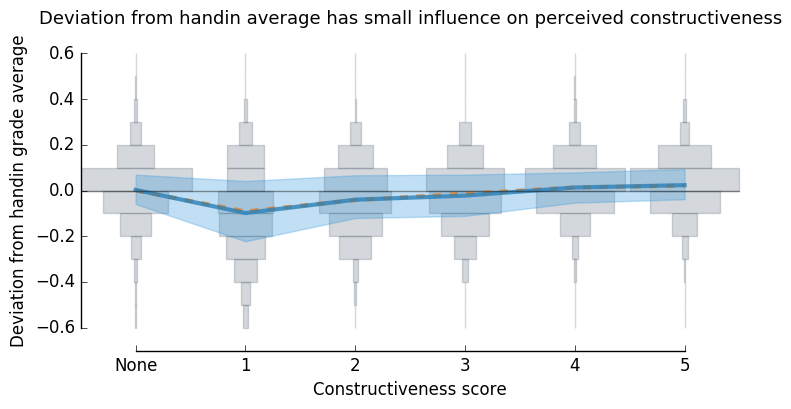

In [26]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(handins[v['handin']])
    )

bins = np.linspace(-0.6, 0.6, 13)

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4), frameon=False)

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    medians.append(np.median(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, bins = np.histogram(h, bins=bins, normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        w = bc/4.0
        rect = mpatches.Rectangle([v-w/2, b], w, abs(bins[0]-bins[1]), lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

plt.plot(range(6), medians, color="#e67e22", lw=3, ls="--", alpha=0.8)
plt.plot(range(6), means, color="#2980b9", lw=3, ls="-", alpha=0.8)
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)
plt.fill_between(range(6), lq, uq, color="#3498db", alpha="0.3")

plt.plot([-0.5, 5.5], [0, 0], c="k", lw=1, alpha=0.4)

plt.xlim([-0.5, 5.5])
plt.ylim([-0.7, 0.7])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6], fontsize=12)

plt.xlabel("Constructiveness score", fontsize=12)
plt.ylabel("Deviation from handin grade average", fontsize=12)

sns.despine(trim=True)
plt.title("Deviation from handin average has small influence on perceived constructiveness", fontsize=13)
plt.savefig("../figures/revenge1.png")
plt.show()

This figure shows that there is very little tendency for students to review feedback as better just because it is very positive relative to the average of all peergradings. This is interesting because it means that it is in fact rarely the case that students avenge negative feedback by rating the feedback quality poorly. This means that it is in fact very likely that students are more careful and tend to give better feedback when grading *good* handins.

### Effect size

In [27]:
def _slope(hists):
    x, y = [], []
    for v, h in hists.items():
        if v > 0:
            x.extend([v]*len(h))
            y.extend(h)
    return stats.linregress(x, y)

slope, intercept, r_value, p_value, std_err = _slope(hists)
print slope, intercept, r_value, p_value, std_err

# shared variance
print r_value ** 2

0.0276574189001 -0.105149582609 0.235933071757 5.41364724324e-34 0.00224272565121
0.0556644143485


## Highlevel feedback features vs. constructiveness score

In [30]:
d_en = enchant.Dict("en_US")

course_lang = defaultdict(list)
get_lang_returns = []

def get_lang(course, sentence):
    if course in globals()['course_lang']:
        return Counter(globals()['course_lang'][course]).most_common(1)[0][0]
    try:
        lang = detect(sentence)
        globals()['course_lang'][course].append(lang)
        return lang
    except: #LangDetectException
        return None
    
def typo_rate(course, sentence):
    """Fraction if words in sentence that are typos."""
    if get_lang(course, sentence) != "en":
        return None
    return np.sum([not d_en.check(w) for w in sentence.split()])

def afinn_rate(course, sentence):
    lang = get_lang(course, sentence)
    globals()['get_lang_returns'].append(lang)
    if lang not in ["en", "da"]:
        return None
    return Afinn(language=lang).score(sentence)

In [31]:
# Main data structure to write to. Every entry is feedback from one person to one handin
ds = defaultdict(lambda: defaultdict(list))

# Book keeping for normalization
handins = defaultdict(list)
assignments = defaultdict(list)
courses = defaultdict(list)

start_date = dateutil.parser.parse('2016-03-30T22:01:37.000Z')

# For printing progress
length_of_collection = db['answer'].find({"_id": {"$gt": ObjectId("56fc4c600000000000000000")}}).count()
increments = np.arange(0, length_of_collection, length_of_collection/10)

breaker = []

c = -1
for answer in db['answer'].find({"_id": {"$gt": ObjectId("56fc4c600000000000000000")}}):

    # Progress counter
    c += 1
    if c in increments:
        print str(list(increments).index(c) * 10) + "%",
        
    # Get question, course and report_grade
    try:
        brokeit="question"
        question = list(
            db['question'].find({"_id": answer["question"]})
        )[0]
        brokeit="report_grade"
        report_grade = list(
                db['report_grade'].find({"_id": answer['report_grade']})
        )[0]
        brokeit="course"
        course = list(
            db['assignment'].find({"_id": report_grade['assignment']})
        )[0]['course']
    except IndexError:
        # something is wrong with this course
        breaker.append(brokeit)
        continue
    
    # Avoid demo courses!
    if "demo" in list(db['course'].find({"_id": course}))[0]["title"].lower():
        continue

    # Compute normalized numerical score. If rubric doesn't have one, set it 
    # to None, and handle it down the road.
    if "numericalAnswers" in question and "numerical_answer" in answer:
        normalized_score = answer['numerical_answer'] * 1.0 / max(map(int, question['numericalAnswers'].keys()))
    elif "boolean_answer" in answer:
        normalized_score = answer['boolean_answer'] * 1.0 / 2
    else:
        normalized_score = None
        
    # Extract text features
    if not 'text_answer' in answer or answer['text_answer'] is None:
        text_length = None
        text_valence = None
        text_typo_rate = None
    else:
        text_length = len(answer['text_answer'])
        text_valence = afinn_rate(course, answer['text_answer'])
        text_typo_rate = typo_rate(course, answer['text_answer'])


    # Set constructive score to zero when it was not given
    if not "feedback_grade" in report_grade:
        feedback_grade = 0
    else:
        feedback_grade = report_grade['feedback_grade']
        if report_grade['feedback_grade'] == 0:
            print "non-demo course has 0 feedback_grade"

    # Feedback case Id
    giver_handin = str(report_grade['giver']) + str(report_grade['handin'])

    # Fill in to main datastructure
    if normalized_score is not None:
        ds[giver_handin]['normalized_scores'].append(normalized_score)
    ds[giver_handin]['feedback_grade'] = feedback_grade

    # For later normalization wrt. different stuff
    ds[giver_handin]['report_grade'] = report_grade['_id']
    ds[giver_handin]['handin'] = report_grade['handin']
    ds[giver_handin]['assignment'] = report_grade['assignment']
    ds[giver_handin]['course'] = course 

    if normalized_score is not None:
        assignments[report_grade['assignment']].append(normalized_score)
        handins[report_grade['handin']].append(normalized_score)
        courses[course].append(normalized_score)

    if text_length is not None:
        ds[giver_handin]['text_length'].append(text_length)
    if text_valence is not None:
        ds[giver_handin]['text_valence'].append(text_valence)
    if text_typo_rate is not None:
        ds[giver_handin]['text_typo_rate'].append(text_typo_rate)

0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


In [32]:
i = 0

In [34]:
i += 1
ds[ds.keys()[i]]

defaultdict(list,
            {'assignment': ObjectId('57d7ac6ff3a028000fafb7ee'),
             'course': ObjectId('57bf04dc763b5e0011373b17'),
             'feedback_grade': 0,
             'handin': ObjectId('57e11b6de2cec3006637fcea'),
             'normalized_scores': [0.0, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5],
             'report_grade': ObjectId('57e81dc7c7052f008a0fc1df'),
             'text_length': [184, 135]})

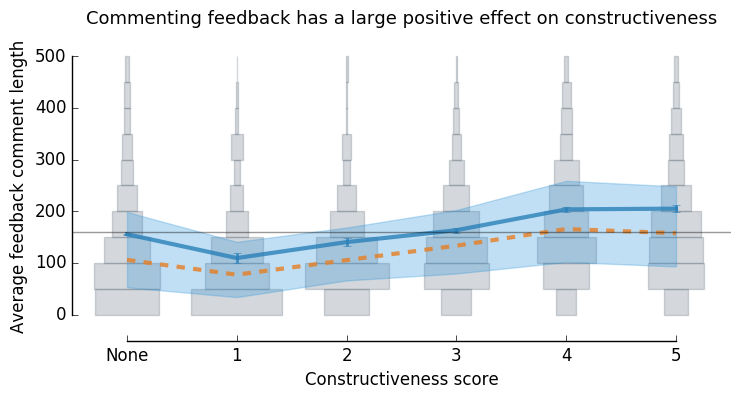

In [651]:
hists = defaultdict(list)
for _, v in ds.items():
    try:
        text_length = np.mean(v['text_length'])
    except KeyError:
        continue
        
    if np.isnan(text_length):
        continue
        
    hists[v['feedback_grade']].append(
        text_length
    )

bins = np.linspace(0, 500, 11)
hists_mean = np.mean([v for h in hists.values() for v in h])

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4), frameon=False)

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    medians.append(np.median(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, _ = np.histogram(h, bins=bins, normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        w = bc*120
        rect = mpatches.Rectangle([v-w/2, b], w, abs(bins[0]-bins[1]), lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

plt.plot(range(6), medians, color="#e67e22", lw=3, ls="--", alpha=0.8)
plt.plot(range(6), means, color="#2980b9", lw=3, ls="-", alpha=0.8)
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)
plt.fill_between(range(6), lq, uq, color="#3498db", alpha="0.3")

plt.plot([-0.5, 5.5], [hists_mean, hists_mean], c="k", lw=1, alpha=0.4)

plt.xlim([-0.5, 5.5])
plt.ylim([-50, 550])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks(np.linspace(0, 500, 6), fontsize=12)

plt.xlabel("Constructiveness score", fontsize=12)
plt.ylabel("Average feedback comment length", fontsize=12)

sns.despine(trim=True)
plt.title("Commenting feedback has a large positive effect on constructiveness", fontsize=13)
plt.savefig("../figures/feedback0.png")
plt.show()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


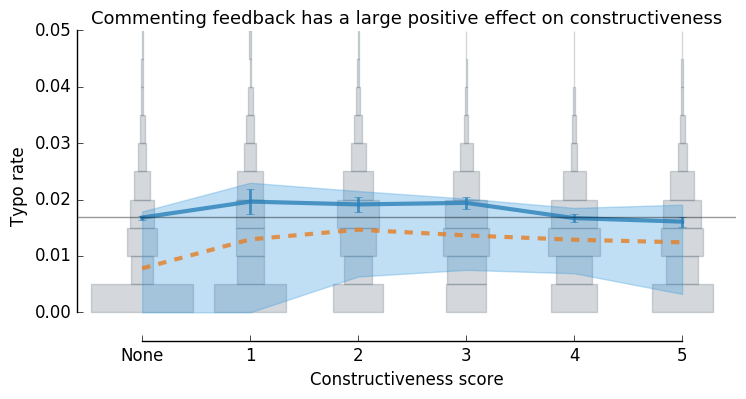

In [660]:
hists = defaultdict(list)
for _, v in ds.items():
    try:
        text_count = np.sum(v['text_length'])
        typo_count = np.sum(v['text_typo_rate'])
        typo_rate = typo_count * 1.0 / text_count
    except KeyError:
        continue
        
    if np.isnan(typo_rate):
        continue
        
    hists[v['feedback_grade']].append(
        typo_rate
    )

bins = np.linspace(0, 0.1, 21)
hists_mean = np.mean([v for h in hists.values() for v in h])

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4), frameon=False)

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    medians.append(np.median(h))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, _ = np.histogram(h, bins=bins, normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        w = bc*0.01
        rect = mpatches.Rectangle([v-w/2, b], w, abs(bins[0]-bins[1]), lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

plt.plot(range(6), medians, color="#e67e22", lw=3, ls="--", alpha=0.8)
plt.plot(range(6), means, color="#2980b9", lw=3, ls="-", alpha=0.8)
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)
plt.fill_between(range(6), lq, uq, color="#3498db", alpha="0.3")

plt.plot([-0.6, 5.5], [hists_mean, hists_mean], c="k", lw=1, alpha=0.4)

plt.xlim([-0.6, 5.5])
plt.ylim([-0.005, 0.05])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks(np.linspace(0, 0.05, 6), fontsize=12)

plt.xlabel("Constructiveness score", fontsize=12)
plt.ylabel("Typo rate", fontsize=12)


sns.despine(trim=True)
plt.title("Commenting feedback has a large positive effect on constructiveness", fontsize=13)
plt.savefig("../figures/feedback1.png")
plt.show()